# Extraction des Sous-Messages pour l'Ingénierie Inverse des Protocoles de Communication Industriels : Preuve de Concept (POC)
### Par: hamza EL ALAOUI
### Ecadré par Dr : gregory faraut
### ENS Paris-saclay 
### Année universitaire : 2025/2026

# _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

## Introduction

### Objectif du projet
L'objectif de ce projet est de reproduire l'algorithme proposé dans l'article **"Sub-messages extraction for industrial control protocol reverse engineering"** de Liu et al. (2022). Cette méthode permet d'extraire des sous-messages à partir des protocoles de communication industriels en utilisant diverses techniques d'analyse de données, comme l'entropie, l'autocorrélation et l'analyse de la diversité des valeurs. Nous allons suivre l'algorithme proposé dans l'article pour prouver son efficacité et sa robustesse dans l'extraction des sous-messages dans des messages capturés dans des protocoles industriels.

### Méthodologie de l'article
L'article propose un algorithme en plusieurs phases pour l'extraction des sous-messages :
1. **Identification de la séparation entre l'en-tête et les données** : Cette phase permet de détecter où se termine l'en-tête fixe d'un message et où commencent les données variables.
2. **Analyse d'autocorrélation pour détecter la périodicité** : Cette phase permet d'identifier la périodicité des sous-messages à l'aide de l'autocorrélation.
3. **Extraction matricielle des segments** : Une fois la périodicité déterminée, cette phase consiste à segmenter le message en sous-messages réguliers.
4. **Inférence de la signature avec analyse de diversité** : À ce stade, l'algorithme analyse la diversité des valeurs dans les segments extraits pour inférer la signature du protocole.
5. **Génération de la carte de chaleur de stabilité** : Cette phase permet de visualiser la stabilité des octets dans les segments extraits. Cela permet de voir quelles parties du message sont fixes (mots-clés) et quelles parties sont dynamiques (données variables).

### Présentation du projet
Dans ce projet, nous allons implémenter et tester chaque phase de cet algorithme. Nous allons commencer par charger les données, puis appliquer chaque étape en suivant les méthodes proposées par l'article, et enfin analyser les résultats. Nous allons aussi visualiser certaines étapes, comme l'analyse de la périodicité et la stabilité des octets, pour mieux comprendre comment l'algorithme fonctionne.


## Phase 1 : Identification de la Séparation entre l'En-tête et les Données

### Explication  : Séparation entre l'En-tête et les Données
Dans cette phase, l’objectif principal est de détecter **où se termine l'en-tête fixe** et **où commencent les données variables** dans un message capturé. L'en-tête fixe contient des informations qui ne changent pas d'un message à l'autre (par exemple, des informations d'identification de protocole), tandis que le **payload** (données variables) contient les informations spécifiques à chaque message.

#### Pourquoi l'entropie ?
L’entropie est une **mesure de l’imprévisibilité** ou du désordre dans une séquence de données. Dans une section de message où les octets sont tous les mêmes (l'en-tête), l'entropie sera faible. En revanche, les données variables (payload) ont souvent une entropie plus élevée car elles contiennent des informations plus diverses.

#### Explication du processus
Nous calculons l'entropie pour chaque fenêtre de 2 octets dans le message. Ensuite, nous analysons le **gradient** de l'entropie pour identifier le point où l'entropie change de manière significative. Ce point de changement nous indique où l'en-tête fixe se termine et où commencent les données.

### Pseudocode
1. Convertir le message hexadécimal en une liste de nombres.
2. Calculer l'entropie pour chaque fenêtre de 2 octets du message.
3. Calculer la pente de l'entropie pour détecter un changement soudain.
4. Identifier l'index où le changement d'entropie est maximal (séparation entre l'en-tête et les données).

### Explication
L'entropie mesure la régularité des octets dans le message. Un changement brutal dans l'entropie nous permet de localiser le point où l'en-tête fixe se termine et où commencent les données variables.


--- RÉSULTATS ---
Le message entier fait 80 octets.
L'en-tête (Header) s'arrête à l'index 4 (zone souvent fixe).
Données utiles (Payload) : ['0x2', '0xf0', '0x80', '0x32', '0x7', '0x0', '0x0', '0x10', '0x0', '0x0', '0xc', '0x0', '0x34', '0x0', '0x1', '0x12', '0x8', '0x12', '0x83', '0x2', '0x1', '0x0', '0x0', '0x0', '0xff', '0x9', '0x0', '0x30', '0x0', '0x0', '0x22', '0x7', '0x0', '0x1', '0x22', '0x7', '0x0', '0x2', '0x22', '0x11', '0x0', '0x3', '0x22', '0x7', '0x0', '0x4', '0x22', '0x7', '0x0', '0x7', '0x22', '0x7', '0x0', '0xc8', '0x22', '0x10', '0x2', '0xbd', '0x22', '0x10', '0xb', '0xb8', '0x22', '0x7', '0x3', '0xe8', '0x22', '0x7', '0x3', '0xea', '0x22', '0x7', '0x3', '0xe9', '0x22', '0x7']


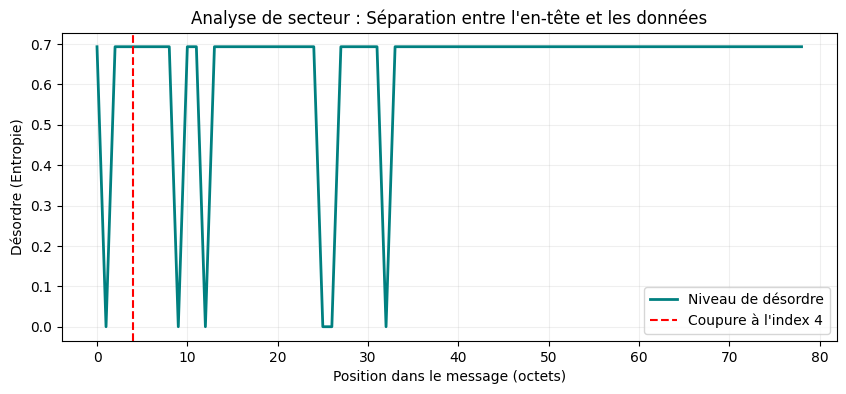

In [157]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import entropy
from collections import Counter

# les DONNÉES BRUTES 
# Voici un message typique capturé sur le réseau (en hexadécimal)
dataset_hex = [
    "03 00 00 51 02 f0 80 32 07 00 00 10 00 00 0c 00 34 00 01 12 08 12 83 02 01 00 00 00 ff 09 00 30 00 00 22 07 00 01 22 07 00 02 22 11 00 03 22 07 00 04 22 07 00 07 22 07 00 c8 22 10 02 bd 22 10 0b b8 22 07 03 e8 22 07 03 ea 22 07 03 e9 22 07"
]

def identification_depart(hex_str):
    # 1. TRANSFORMATION : On transforme le texte en nombres pour que l'ordi puisse calculer
    # "03" devient 3, "00" devient 0, etc.
    data = [int(x, 16) for x in hex_str.split()]
    
    # 2. LA LOUPE (Fenêtre) : On va regarder le message 2 octets par 2 octets
    window = 2
    h_scores = []
    
    # On parcourt le message du début à la fin
    for i in range(len(data) - window + 1):
        # On prend un petit bloc (secteur) de 2 octets
        bloc = data[i : i + window]
        
        # CALCUL DU DÉSORDRE (Entropie) : 
        # Si le bloc est [00, 00], le désordre est de 0.
        # Si le bloc est [c1, 02], le désordre est élevé.
        _, counts = np.unique(bloc, return_counts=True)
        probabilites = counts / window
        h_scores.append(entropy(probabilites))
    
    # 3. DÉTECTION DU CHANGEMENT : On cherche où le désordre augmente d'un coup
    # Le "gradient" calcule la pente de la courbe. Une pente forte = un changement de zone.
    gradient = np.gradient(h_scores)
    
    # On trouve l'endroit où la pente est la plus raide (le maximum)
    # C'est ici que finit l'en-tête fixe et que commencent les données variables.
    payload_start = np.argmax(gradient) + window
    
    return data, h_scores, payload_start

# --- LANCEMENT DE L'ANALYSE ---
raw_data, scores_h, start_idx = phase1_identification_depart(dataset_hex[0])

# --- EXPLICATIONS DES RÉSULTATS ---
print(f"--- RÉSULTATS ---")
print(f"Le message entier fait {len(raw_data)} octets.")
print(f"L'en-tête (Header) s'arrête à l'index {start_idx} (zone souvent fixe).")
# On affiche ce qu'on a extrait pour la suite de l'algorithme
print(f"Données utiles (Payload) : {[hex(x) for x in raw_data[start_idx:]]}")

# --- DESSIN POUR LE RAPPORT ---
plt.figure(figsize=(10, 4))
# On dessine la courbe du désordre (Entropie)
plt.plot(scores_h, label='Niveau de désordre', color='teal', linewidth=2)
# On trace une ligne rouge là où l'algorithme a décidé de couper
plt.axvline(x=start_idx, color='red', linestyle='--', label=f'Coupure à l\'index {start_idx}')
plt.title("Analyse de secteur : Séparation entre l'en-tête et les données")
plt.xlabel("Position dans le message (octets)")
plt.ylabel("Désordre (Entropie)")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

## Phase 2 : Analyse d'Autocorrélation pour Détecter la Périodicité

### Explication : Détection de la Périodicité

Une fois la séparation entre l'en-tête et les données effectuée, la prochaine étape consiste à **détecter la périodicité** des sous-messages dans la charge utile. La **périodicité** est essentielle pour segmenter les messages en blocs réguliers qui contiennent des informations structurées.

#### Pourquoi l’autocorrélation ?
L’autocorrélation mesure la **similarité** entre des segments de données séparés par un certain décalage. Si un protocole utilise une périodicité régulière, alors les octets situés à des positions espacées par une certaine valeur \( k \) seront similaires. Calculer l’autocorrélation pour différents lags (décalages) nous aide à identifier cette périodicité.

#### Explication du Code
Nous calculons l'autocorrélation pour différents décalages \( k \) dans la charge utile et identifions la **périodicité** \( k^* \), qui nous aide à segmenter correctement les messages en blocs réguliers.

### Pseudocode
1. Extraire la charge utile à partir de l'index de séparation.
2. Calculer l'autocorrélation pour chaque décalage \(k\).
3. Identifier le décalage \(k^*\) qui maximise l'autocorrélation.
4. Vérifier si l'autocorrélation dépasse un seuil prédéfini.

### Explication
L'autocorrélation permet de repérer les motifs récurrents dans les données. Cela nous aide à déterminer la longueur des sous-messages, ce qui est essentiel pour la segmentation.


---  RÉSULTATS  ---
Périodicité optimale (k*) détectée : 4 octets


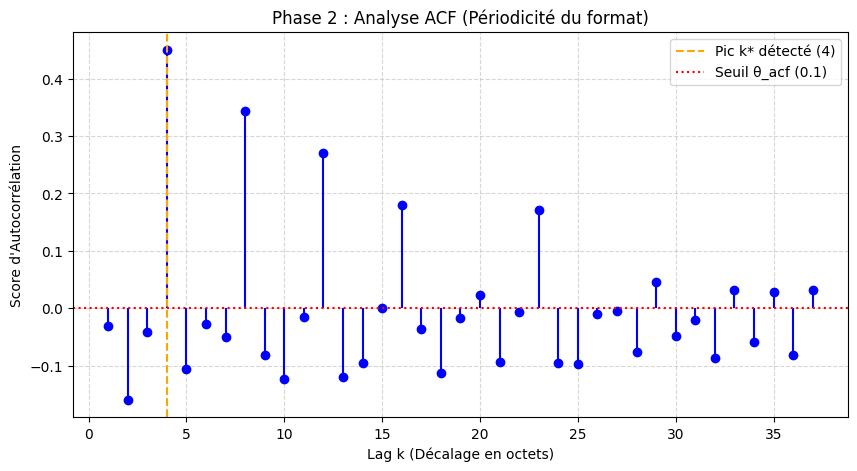

In [158]:

def autocorrelation_analysis(payload_seq, theta_acf=0.1):

    B = np.array(payload_seq)
    n = len(B)
    
    # Calcul de la moyenne et de la variance 
    mu = np.mean(B)
    denominator = np.sum((B - mu)**2)
    
    # On définit la plage de recherche (lags)
    # n // 2 est la limite statistique maximale pour un lag
    lags = range(1, max(2, n // 2))
    acf_scores = []
    
    for k in lags:
        # Formule de corrélation de l'Algorithme 1, Ligne 9
        numerator = np.sum((B[:-k] - mu) * (B[k:] - mu))
        score = numerator / denominator if denominator != 0 else 0
        acf_scores.append(score)
    
    # k* est le décalage qui donne le score le plus élevé au-dessus du seuil theta_acf
    if len(acf_scores) > 0 and max(acf_scores) > theta_acf:
        k_star = lags[np.argmax(acf_scores)]
    else:
        k_star = 1 # Par défaut selon l'article si aucune périodicité n'est claire
        
    return list(lags), acf_scores, k_star

# --- EXÉCUTION : On utilise le Payload B extrait au Bloc 1 ---
# Note : 'raw_data' et 'start_idx' viennent directement du Bloc 1 au-dessus
payload_B = raw_data[start_idx:]
lags, acf_vals, k_star = phase2_autocorrelation_analysis(payload_B)

print(f"---  RÉSULTATS  ---")
print(f"Périodicité optimale (k*) détectée : {k_star} octets")

# Visualisation type 'Stem' (exactement comme dans l'article SEIP)
plt.figure(figsize=(10, 5))
markerline, stemlines, baseline = plt.stem(lags, acf_vals, basefmt=" ", linefmt='b-', markerfmt='bo')
plt.axvline(x=k_star, color='orange', linestyle='--', label=f'Pic k* détecté ({k_star})')
plt.axhline(y=0, color='red', linestyle=':', label='Seuil θ_acf (0.1)')

plt.title("Phase 2 : Analyse ACF (Périodicité du format)")
plt.xlabel("Lag k (Décalage en octets)")
plt.ylabel("Score d'Autocorrélation")
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()

## Phase 3 : Extraction Matricielle des Segments

### Explication : Segmentation des Messages

Une fois la périodicité \( k^* \) détectée, cette phase consiste à **segmenter** les messages en sous-messages de taille \( k^* \). Ces sous-messages sont essentiels pour comprendre la structure des données dans le protocole et pour en extraire des informations spécifiques.

#### Pourquoi utiliser la segmentation matricielle ?
La segmentation matricielle permet d'aligner les segments extraits et de les organiser dans une matrice. Cela nous aide à analyser les segments plus facilement et à ajuster notre modèle d'extraction de manière itérative jusqu'à obtenir un résultat stable.

#### Explication du Code
Nous effectuons une segmentation des messages à l'aide de la périodicité \( k^* \), puis nous réajustons les segments de manière itérative. Une fois que les segments sont stables et cohérents, nous pouvons les extraire pour l'analyse.

### Pseudocode
1. Utiliser la périodicité \(k^*\) pour segmenter les messages.
2. Itérer pour aligner les segments et mettre à jour le modèle de segmentation.
3. Converger vers un modèle stable où les segments ne changent plus.
4. Extraire tous les segments alignés.

### Explication
Nous segmentons les messages en sous-messages de taille \(k^*\) et ajustons le modèle d'extraction pour garantir que tous les segments sont alignés et cohérents.


In [159]:
def extraction_matricielle(dataset_hex, start_idx, k_star):
    all_payloads = []
    for hex_str in dataset_hex:
        msg_bytes = [int(x, 16) for x in hex_str.split()]
        if len(msg_bytes) > start_idx:
            all_payloads.append(msg_bytes[start_idx:])

    if not all_payloads:
        return []

    # Initialisation et boucle de convergence (Algorithme 1)
    template = np.array(all_payloads[0][:k_star])
    iteration = 0
    sac_segments_final = []

    while True:
        current_segments = []
        for B in all_payloads:
            for i in range(0, len(B) - len(template) + 1, len(template)):
                current_segments.append(B[i : i + len(template)])
        
        if not current_segments: break
        
        matrix = np.array(current_segments)
        new_template = np.array([np.argmax(np.bincount(matrix[:, c])) for c in range(matrix.shape[1])])

        if np.array_equal(template, new_template) or iteration > 10:
            sac_segments_final = current_segments
            break
        template = new_template
        iteration += 1

    # --- PARTIE AMÉLIORATION : AFFICHAGE MATRICIEL ---
    print(f"\n--- MATRICE D'ALIGNEMENT DES SEGMENTS (K*={k_star}) ---")
    
    # Création d'un DataFrame pour une visualisation structurée
    df = pd.DataFrame(sac_segments_final)
    df.columns = [f"Byte_{i+1:02d}" for i in range(df.shape[1])]
    
    # Transformation de toute la matrice en Hexadécimal pour la lecture
    df_hex = df.map(lambda x: f"{x:02x}")
    
    # Affichage de TOUTES les lignes (Segments)
    # pd.set_option('display.max_rows', None) # Optionnel : décommentez pour TOUT voir
    print(df_hex.to_string(index=True))
    
    print("-" * 50)
    print(f"Total de segments alignés : {len(sac_segments_final)}")
    
    return sac_segments_final

# --- EXÉCUTION ---
# Remplacez votre ancien appel par celui-ci
sac_segments = phase3_extraction_matricielle(dataset_hex, start_idx, k_star)


--- MATRICE D'ALIGNEMENT DES SEGMENTS (K*=4) ---
   Byte_01 Byte_02 Byte_03 Byte_04
0       02      f0      80      32
1       07      00      00      10
2       00      00      0c      00
3       34      00      01      12
4       08      12      83      02
5       01      00      00      00
6       ff      09      00      30
7       00      00      22      07
8       00      01      22      07
9       00      02      22      11
10      00      03      22      07
11      00      04      22      07
12      00      07      22      07
13      00      c8      22      10
14      02      bd      22      10
15      0b      b8      22      07
16      03      e8      22      07
17      03      ea      22      07
18      03      e9      22      07
--------------------------------------------------
Total de segments alignés : 19


## Phase 4 : Inférence de la Signature avec Analyse de Diversité

### Explication : Inférence de la Signature

Cette phase permet d'inférer la **signature** du protocole en analysant la fréquence des valeurs dominantes dans chaque segment. Nous utilisons cette analyse pour classer les segments en trois catégories : **fixes** (mots-clés), **multi-valeurs** (champ dynamique) et **aléatoires** (données variables).

#### Pourquoi analyser la diversité des valeurs ?
L’analyse de la diversité des valeurs nous permet de comprendre quelles parties du protocole sont fixes (par exemple, les identifiants ou mots-clés) et quelles parties varient en fonction des messages (données ou champs dynamiques). Une faible diversité des valeurs indique un champ stable, tandis qu'une grande diversité signifie que les valeurs changent fréquemment.

#### Explication du Code
Nous analysons la fréquence des valeurs dans chaque colonne de la matrice de segments. Selon la fréquence et la diversité des valeurs, nous classons chaque segment comme "fixe", "multi-valeurs" ou "aléatoire".

### Pseudocode
1. Analyser la fréquence des valeurs dans chaque segment.
2. Classer les segments comme "fixes", "multi-valeurs", ou "aléatoires".
3. Utiliser la fréquence et la diversité des valeurs pour inférer la signature du protocole.
4. Retourner la signature sous forme de liste de classifications.

### Explication
Dans cette phase, nous analysons les segments extraits pour déterminer quelles parties sont fixes (mots-clés) et quelles parties sont dynamiques (données).


In [160]:
def inference_expert(segments, theta_freq=0.7):

    if not segments:
        print("Erreur : Aucun segment disponible.")
        return
        
    matrix = np.array(segments)
    nb_segs, taille = matrix.shape
    signature_finale = []
    
    print(f"{'POS':<5} | {'VALEUR':<8} | {'CONFIANCE':<10} | {'DIVERSITÉ':<12} | {'TYPE SEIP'}")
    print("-" * 70)
    
    for c in range(taille):
        colonne = matrix[:, c]
        comptage = Counter(colonne)
        
        # On extrait la valeur la plus fréquente (Logique FP-Tree)
        octet_fav, count_fav = comptage.most_common(1)[0]
        nb_uniques = len(comptage)
        stabilite = count_fav / nb_segs
        
        # Classification selon la sémantique de l'article
        if stabilite >= theta_freq:
            res_hex = f"{int(octet_fav):02x}"
            statut = "KEYWORD (Fixe)"
        elif nb_uniques <= 5: # Amélioration : Champ à choix multiples
            res_hex = "??"
            statut = "FIELD (Multi-valeurs)"
        else:
            res_hex = "??"
            statut = "DATA (Aléatoire)"
            
        signature_finale.append(res_hex)
        
        # Affichage structuré pour votre manuscrit
        print(f"#{c+1:02d}  | 0x{int(octet_fav):02x}   | {stabilite:>9.1%} | {nb_uniques:>2} valeurs  | {statut}")

    sig_str = " ".join(signature_finale)
    print("-" * 70)
    print(f"\nSIGNATURE FINALE : [ {sig_str} ]")
    return sig_str


signature_seip = inference_expert(sac_segments, theta_freq=0.6)

POS   | VALEUR   | CONFIANCE  | DIVERSITÉ    | TYPE SEIP
----------------------------------------------------------------------
#01  | 0x00   |     42.1% |  9 valeurs  | DATA (Aléatoire)
#02  | 0x00   |     26.3% | 15 valeurs  | DATA (Aléatoire)
#03  | 0x22   |     63.2% |  6 valeurs  | KEYWORD (Fixe)
#04  | 0x07   |     47.4% |  8 valeurs  | DATA (Aléatoire)
----------------------------------------------------------------------

SIGNATURE FINALE : [ ?? ?? 22 ?? ]


## Phase 5 : Génération de la Carte de Chaleur de Stabilité

### Explication : Génération de la Carte de Chaleur

La dernière phase du processus consiste à **générer une carte de chaleur** qui permet de visualiser la **stabilité des octets** dans les segments extraits. Cette carte de chaleur fournit une vue d'ensemble de la structure du message, indiquant clairement quelles parties sont fixes et quelles parties varient.

#### Pourquoi la carte de chaleur ?
La carte de chaleur est un outil visuel très efficace qui permet d'identifier rapidement les zones stables (mots-clés) et les zones dynamiques (données). Chaque octet est coloré en fonction de sa stabilité, ce qui facilite l'analyse visuelle du protocole.

#### Explication du Code
Nous calculons la **stabilité** des octets dans chaque segment et générons une carte de chaleur pour visualiser cette stabilité. Les couleurs dans la carte représentent la stabilité de chaque octet.

### Pseudocode
1. Calculer la stabilité pour chaque position d'octet dans les segments.
2. Générer une carte de chaleur pour visualiser la stabilité.
3. Afficher la carte de chaleur avec les couleurs représentant la stabilité des octets.

### Explication
La carte de chaleur nous permet de voir visuellement les octets les plus stables (mots-clés) et les plus variables (données).


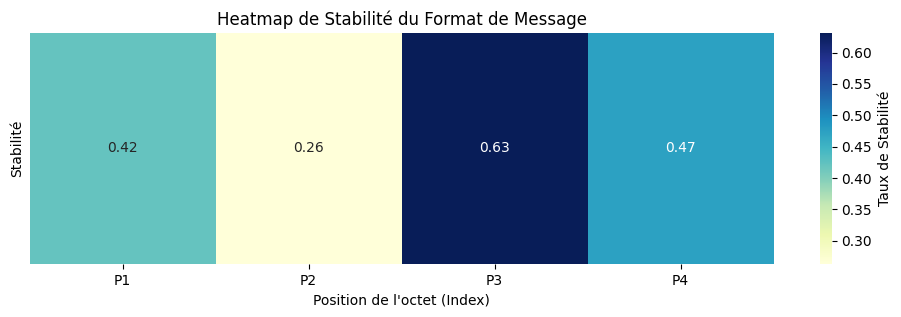

In [161]:
def generer_heatmap_seip(segments):
   
    if not segments:
        print("Aucun segment à afficher.")
        return

    # 1. Calcul de la probabilité de l'octet dominant pour chaque position
    matrix = np.array(segments)
    nb_segs, taille = matrix.shape
    stabilites = []

    for c in range(taille):
        counts = np.bincount(matrix[:, c])
        prob = np.max(counts) / nb_segs
        stabilites.append(prob)

    # 2. Préparation des données pour Seaborn
    data_plot = np.array(stabilites).reshape(1, -1)
    
    # 3. Création du graphique
    plt.figure(figsize=(12, 3))
    ax = sns.heatmap(data_plot, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Taux de Stabilité'})
    
    # Configuration des axes
    plt.title("Heatmap de Stabilité du Format de Message")
    plt.xlabel("Position de l'octet (Index)")
    plt.ylabel("Stabilité")
    
    # On affiche les index de 1 à N
    plt.xticks(np.arange(taille) + 0.5, [f"P{i+1}" for i in range(taille)])
    plt.yticks([]) # On cache l'axe Y (une seule ligne)

    plt.show()

# --- EXÉCUTION ---
generer_heatmap_seip(sac_segments)

## Conclusion

### Résumé des résultats

En résumé, ce projet démontre qu'il est possible d'identifier **un protocole spécifique** à partir d'une adresse réseau et des messages capturés en utilisant des méthodes statistiques d'extraction de sous-messages, même sans documentation préalable du protocole. Grâce à l'analyse d'entropie, d'autocorrélation, et de diversité des valeurs, nous avons pu segmenter les messages en sous-messages réguliers et identifier des motifs récurrents.

### Applications possibles de la segmentation finale

#### Identification des protocoles inconnus
Une fois les sous-messages extraits, nous pouvons tenter d'analyser les **patterns récurrents** dans les données et les associer à des protocoles connus par **analyse statistique**. Par exemple, à partir de l'adresse réseau et des segments extraits, il est possible d'inférer quel protocole est probablement utilisé, sans avoir besoin de la documentation officielle. Ces inférences peuvent être utilisées pour déterminer la **structure du protocole**, les différents types de champs et les motifs de communication.

#### Création de bases de données de signatures de protocole
La segmentation et l'inférence des sous-messages permettent de créer une **base de données de signatures** pour différents protocoles. Chaque adresse réseau et ses segments extraits pourraient ainsi être associés à une **signature statistique** qui peut ensuite être utilisée pour détecter et identifier des protocoles dans des communications futures.

#### Analyse des communications sans documentation préalable
L'algorithme utilisé permet de **segmenter un message capturé**, d'identifier des **motifs récurrents** et de déduire la **structure sous-jacente** sans accès à une documentation formelle du protocole. Cela est particulièrement utile dans des environnements où la documentation est absente ou incomplète, comme dans les réseaux industriels privés ou les systèmes de communication propriétaires.

### Limites et améliorations possibles
- Sans un protocole bien documenté, il est impossible de valider les sous-messages extraits et leur signification.
- Tester sur des protocoles plus variés et ajouter une gestion plus robuste du bruit.
- Optimiser les algorithmes pour des protocoles plus complexes et les protocoles privés.

### Applications futures
Ce travail peut être utilisé pour l'analyse des protocoles dans des systèmes industriels, notamment pour la **sécurité** des protocoles de communication et la détection de vulnérabilités.


## Références
1. Liu, Y., Zhang, F., Ding, Y., Jiang, J., & Yang, S.-H. (2022). Sub-messages extraction for industrial control protocol reverse engineering. *Computer Communications, 194*, 1-14.